# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
hsi_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_data/1500.npz'
gt_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_gt.csv'
wavelength_path = 'D:/datasets/soilHyperspec/train_data/train_data/wavelengths.csv'

In [3]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [4]:
gt_df[gt_df['sample_index']==150]

,sample_index,P,K,Mg,pH
150,150,140.0,312.0,216.0,7.4


## Displaying one hyperspectral band

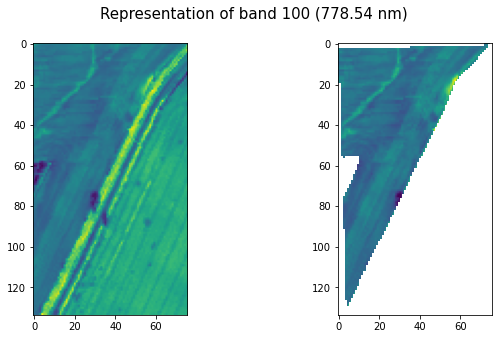

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])

plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

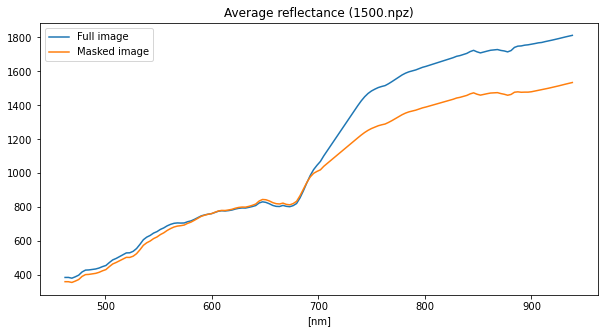

In [6]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Shapes and DS size

In [7]:
import os
trainSize = len(os.listdir('D:/datasets/soilHyperspec/train_data/train_data/train_data'))
print('Amount training images:',trainSize)                           

Amount training images: 1733


In [8]:
hsi_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_data/1500.npz'

sizes = []
for file in os.listdir('D:/datasets/soilHyperspec/train_data/train_data/train_data'):
    if file == '.DS_Store':
        continue
    with np.load('D:/datasets/soilHyperspec/train_data/train_data/train_data/' + file) as npz:
        arr = np.ma.MaskedArray(**npz)
        sizes.append(arr.shape[1:3])

In [9]:
import sys
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=False)
print(np.unique(sizes,axis=0))

[[ 11  11]
 [ 16  71]
 [ 17  93]
 ...
 [213 108]
 [217  68]
 [268  32]]


# Inspect bands - One Image

In [10]:
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

print(arr.data.shape)

(150, 134, 76)


In [11]:
#may use for masked image
#cleanArr = np.delete(arr, np.where(arr == None))

In [12]:
newArr = np.transpose(arr.data.reshape(150, 10184))
newArrMasked = np.transpose(arr.reshape(150, 10184))

In [13]:
print(newArr[0][0:10])
print(newArr.shape)

[480 487 480 ... 546 548 550]
(10184, 150)


In [14]:
#For masked image - cut out masked vals

In [15]:
#Get means, histogram of values, range
#A row represents same pixel over different bands
#Columns represent different pixels over one band
#Should I normalise the pixel values?

In [38]:
import pandas as pd

#bands as list
bands = [i for i in range (1,151)]

def bandOverview(arr):
    #Mean of each column (same pixel)
    means = list(np.mean(arr, axis = 0))

    #maxs/mins
    ma = list(np.max(arr, axis = 0))

    mi = list(np.min(arr, axis = 0))

    #range of each column
    ranges = list(np.ptp(arr, axis=0))

    #standard deviation
    stds = list(np.std(arr, axis=0))
    #show first 10 and last 10 bands
    df = pd.DataFrame({"Band": bands[0:10]+['...']+bands[-10:],
                           "Mean": means[0:10]+['...']+means[-10:],
                           "Min": mi[0:10]+['...']+mi[-10:],
                           "Max": ma[0:10]+['...']+ma[-10:],
                           "Range": ranges[0:10]+['...']+ranges[-10:],
                           "std dev": stds[0:10]+['...']+stds[-10:]})
    df = df.set_index('Band')

    return df, means, ma, mi, ranges, stds

def bandOverviewComplete(arr): #includes all data
    #Mean of each column (same pixel)
    means = list(np.mean(arr, axis = 0))
    
    print("Means calculated!")
    #maxs/mins
    ma = list(np.max(arr, axis = 0))
    print("Maxs calculated!")

    mi = list(np.min(arr, axis = 0))
    print("Mins calculated!")
    
    #range of each column
    ranges = list(np.ptp(arr, axis=0))
    print("Ranges calculated!")
    
    #standard deviation
    stds = list(np.std(arr, axis=0))
    print("Std. Dev. calculated!")
    
    #show first 10 and last 10 bands
    df = pd.DataFrame({"Band": bands,
                           "Mean": means,
                           "Min": mi,
                           "Max": ma,
                           "Range": ranges,
                           "std dev": stds})
    df = df.set_index('Band')
    
    print("Dataframe Created!\n")
    return df, means, ma, mi, ranges, stds


df, means, ma, mi, ranges, stds = bandOverview(newArr)
dfM, meansM, maM, miM, rangesM, stdsM = bandOverview(newArrMasked)

In [29]:
print('Full Image Stats')
display(df)
print('Masked Image Stats')
display(dfM)

Full Image Stats


,Mean,Min,Max,Range,std dev
Band,,,,,
1,356.030362,262,534,272,37.794352
2,356.702551,259,537,278,38.023631
3,353.287748,255,530,275,37.851862
4,361.42022,267,538,271,38.48149
5,371.683465,276,549,273,39.175408
6,390.843528,294,577,283,40.470537
7,402.62022,303,594,291,41.33561
8,405.044724,299,602,303,41.698001
9,408.999118,306,613,307,42.234152


Masked Image Stats


,Mean,Min,Max,Range,std dev
Band,,,,,
1,362.163824,117,779,662,51.476966
2,362.033438,121,785,664,51.821663
3,357.669434,122,785,663,51.774647
4,365.604354,132,798,666,52.664898
5,374.779399,139,819,680,53.666719
6,393.208707,151,858,707,55.506788
7,403.841562,151,877,726,56.834057
8,405.033887,151,884,733,57.489535
9,407.815081,149,894,745,58.323684


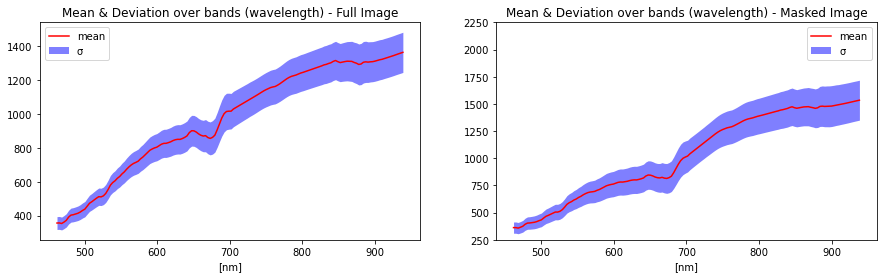

In [30]:
import matplotlib.pyplot as plt
def plotBands(means,stds,title):
    plt.title(title)

    plt.plot(wavelength_df['wavelength'],means, color='red')
    
    stdHigher = np.array(means) + np.array(stds)
    stdLower = np.array(means) - np.array(stds)
    plt.xlabel('[nm]')
    plt.fill_between(
        wavelength_df['wavelength'],
        stdHigher,
        stdLower,
        color='blue',
        alpha=0.5,
        linewidth=0,
        )
    plt.legend(['mean','\u03C3'])
    
plt.figure(figsize=(15,4))
plt.ylim(250,2250)
plt.subplot(1, 2, 1)
plotBands(means,stds,'Mean & Deviation over bands (wavelength) - Full Image')
plt.subplot(1, 2, 2)
plt.ylim(250,2250)
plotBands(meansM,stdsM,'Mean & Deviation over bands (wavelength) - Masked Image')

# Inspect bands - All Images

In [59]:
from tqdm.notebook import tqdm

#if exists


#load in data, reshape and stack it
for i in tqdm(range(0,1732,2)): #range(0,1732,1) for every 10nth
    path = r"D:/datasets/soilHyperspec/train_data/train_data/train_data/" + str(i) + ".npz"
    with np.load(path) as npz:
        arr = np.ma.MaskedArray(**npz)
#     print(arr.shape)
    reshapeRatio = (arr.shape[1])*(arr.shape[2])
    newArr = np.transpose(arr.data.reshape(150, reshapeRatio))
    newArrmasked = np.transpose(arr.reshape(150, reshapeRatio))
#     print(newArr.shape)
#     print(newArrmasked.shape)
#     break
    if i == 0:
        allIms = newArr
        allImsM = newArrmasked
    else:
        allIms = np.vstack((allIms,newArr))
        allImsM = np.vstack((allImsM,newArrmasked))

  0%|          | 0/866 [00:00<?, ?it/s]

In [60]:
#save as an npz

#few obs than features? - no solution via Singular value decomposition

In [61]:
print(allIms.shape)
print(allImsM.shape)

(4920213, 150)
(4920213, 150)


In [63]:
import os
if os.path.exists('allFullImMetrics.csv'):
    print("Full Images CSV exists, loading metrics...")
    #load csv
    df = pd.read_csv('allFullImMetrics.csv')
    means = list(df['Mean'])
    ma = list(df['Max'])
    mi = list(df['Min'])
    ranges = list(df['Range'])
    stds = list(df['std dev'])
    print("Done!")
else:
    #create and save one
    df, means, ma, mi, ranges, stds = bandOverviewComplete(allIms)
    df.to_csv('allFullImMetrics.csv')
    
if os.path.exists('allMaskedImMetrics.csv'):
    print("Masked Images CSV exists, loading metrics...")
    #load csv
    dfM = pd.read_csv('allMaskedImMetrics.csv')
    meansM = list(dfM['Mean'])
    maM = list(dfM['Max'])
    miM = list(dfM['Min'])
    rangesM = list(dfM['Range'])
    stdsM = list(dfM['std dev'])
    print("Done!")
else:
    #create and save one
    dfM, meansM, maM, miM, rangesM, stdsM = bandOverviewComplete(allImsM)
    dfM.to_csv('allMaskedImMetrics.csv')

Means calculated!
Maxs calculated!
Mins calculated!
Ranges calculated!
Std. Dev. calculated!
Dataframe Created!

Means calculated!
Maxs calculated!
Mins calculated!
Ranges calculated!
Std. Dev. calculated!
Dataframe Created!



In [64]:
print('Full Images Stats')
display(df)
print('Masked Images Stats')
display(dfM)

Full Images Stats


,Mean,Min,Max,Range,std dev
Band,,,,,
1,337.008420,-3,5190,5193,95.257120
2,337.161232,-1,5183,5184,95.571901
3,333.125735,-3,5115,5118,95.288205
4,340.352501,-8,5154,5162,96.736000
5,349.320436,0,5201,5201,98.672869
...,...,...,...,...,...
146,1782.817260,15,7524,7509,949.667127
147,1785.124381,14,7499,7485,946.097524
148,1786.986142,13,7474,7461,942.103012


Masked Images Stats


,Mean,Min,Max,Range,std dev
Band,,,,,
1,337.008420,-3,5190,5193,95.257120
2,337.161232,-1,5183,5184,95.571901
3,333.125735,-3,5115,5118,95.288205
4,340.352501,-8,5154,5162,96.736000
5,349.320436,0,5201,5201,98.672869
...,...,...,...,...,...
146,1782.817260,15,7524,7509,949.667127
147,1785.124381,14,7499,7485,946.097524
148,1786.986142,13,7474,7461,942.103012


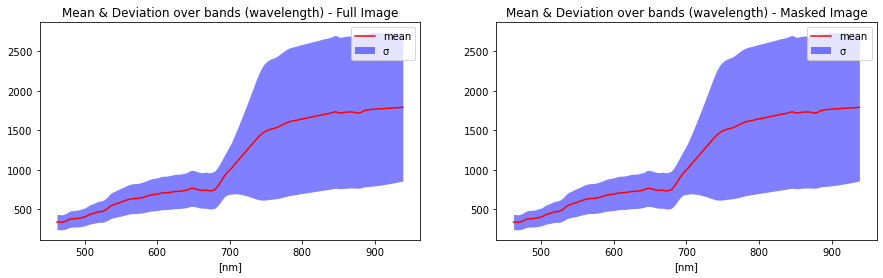

In [65]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
#plt.ylim(400,1750)
plotBands(means,stds,'Mean & Deviation over bands (wavelength) - Full Image')
plt.subplot(1, 2, 2)
#plt.ylim(400,1750)
plotBands(meansM,stdsM,'Mean & Deviation over bands (wavelength) - Masked Image')

# Dimenstionality Reduction with PCA

In [66]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(allImsM)#fitting all masked images
fullImPca = PCA()
fullImPca.fit(allIms)
#save PCA as an object?
#PCA ran with all components kept
#svd solver randomized/full

PCA()

In [67]:
varRat = pca.explained_variance_ratio_
fullImVarRat = fullImPca.explained_variance_ratio_

(150,) (150,)


Text(0, 0.5, '% variance')

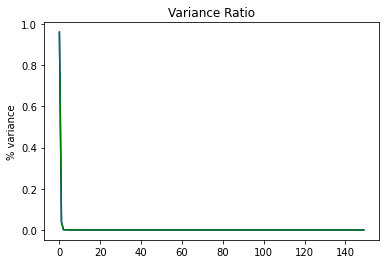

In [68]:
print(varRat.shape,fullImVarRat.shape)# why 121 not 150
#plot data variance ratio
plt.figure()
x = np.linspace(0,121)
plt.plot(varRat,'blue')
plt.title('Variance Ratio')
plt.plot(fullImVarRat,'green')

#why graph flat? - incorrect code?
plt.ylabel('% variance')

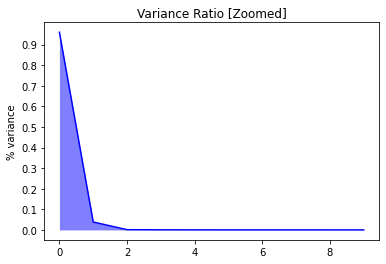

In [69]:
plt.figure()
plt.ylabel('% variance')
plt.title('Variance Ratio [Zoomed]')
plt.plot(varRat[:10],'blue')
plt.yticks(np.arange(0, 1, 0.1))
x = np.arange(10)
plt.fill_between(
        x,
        varRat[:10],
        color='blue',
        alpha=0.5,
        linewidth=0,
        )

In [70]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print(varRat)

[0.959600 0.038306 0.001107 ... 0.000000 0.000000 0.000000]


In [71]:
print(varRat-fullImVarRat)#they're the same???

#save data as csv - save PCA object
#scatterplot showing pca loadings
#plot [pixels transformed as pca]

[0.000000 0.000000 0.000000 ... 0.000000 0.000000 0.000000]


In [72]:
#transform masked
maskedRx = pca.transform(allImsM)

Since you did a full PCA you get 2 such vectors so you get a 2x2 matrix. The first of those vectors will maximize the variance of the projected data. The 2nd will maximize the variance of what's left after the first projection. 

In [73]:
print(maskedRx.shape)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print(maskedRx)

(4920213, 150)
[[-767.877653 2592.830944 11.110044 ... 0.269024 0.476348 -0.183113]
 [-959.754593 2339.164003 83.167556 ... -0.020443 0.364923 0.374493]
 [-840.318701 2298.431478 29.135181 ... -0.216315 0.112965 0.556880]
 ...
 [-3780.416085 473.806153 60.336678 ... 0.028050 0.164159 0.146590]
 [-3676.631696 487.778829 68.291141 ... 0.292383 0.424813 0.000400]
 [-4147.081319 285.075091 45.089387 ... 0.223790 -0.239189 0.007481]]


In [ ]:
#scatter transformed data

In [ ]:
#To Do:
#What n values to we keep from transformed values- (first 2 for 95% variance?)
#How to now plot pH values on image (features correspond to a whole image)
#Do we highlight areas of correlation?
#Next steps

# Miscellaneous Testing

In [28]:
#testing & debugging reshape
np.set_printoptions(threshold=sys.maxsize)
test1 = [[1,9,3],[1,8,3],[5,2,3]],[[1,2,2],[9,2,3],[1,2,4]]
test1 = np.array(test1)
print(test1.shape)
test2 = test1.reshape((2,9))
print(test2)

(2, 3, 3)
[[1 9 3 1 8 3 5 2 3]
 [1 2 2 9 2 3 1 2 4]]
